TP - DCGAN
=============

By Sohaib Errabii

This notebook is devoted to the investigation of the DCGAN model


In [1]:
import random
import numpy as np
from typing import Tuple
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
import torchvision as tv
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


# Set random seed for reproducibility
manualSeed = 40
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  40


Params
------

Let’s define some global parameters / Hyper-parameters according to the DCGAN paper.

In [2]:
# Directory containing folder "img_align_celeba"
celeba_root = 'data'

# Number of workers for dataloader
workers = 2

# The resolution in pixels of the images need to be 64x64 for DCGAN.
img_size = 64 

# Number of channels (colors in images)
nc = 3

# Dimension of generator input 
z_dim = 100

# Number of feature maps before output in descriminator & generator
nf = 64

# Number of training epochs of DCGAN
num_epochs = 5

# Batch size during training
batch_size = 128

# Learning rate for optimizers from DCGAN paper
lr = 0.0002

# Slope of the leak for LeakyReLU in the discriminator
slru = 0.2

# Betas[0] of ADAM set to 0.5 like in the paper
betas = (0.5, 0.999)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data
----

For the data, i extract the faces from the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) Dataset.

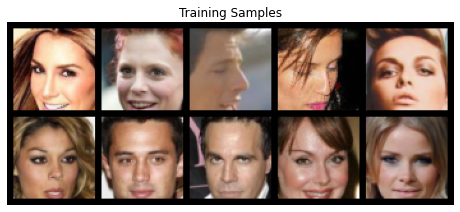

In [3]:
# Transform to extract faces and normalize them from raw CelebA images
crop_size = 108
faces_transform = tv.transforms.Compose([
    tv.transforms.CenterCrop(crop_size),
    tv.transforms.Resize(img_size),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])

# Create the dataset
celeba_dataset = tv.datasets.ImageFolder(celeba_root, faces_transform) 

# Create the dataloader
celeba_loader = DataLoader(celeba_dataset, batch_size=batch_size, num_workers=workers)

# Visualize data
batch_tensor, _ = next(iter(celeba_loader))
grid_img = tv.utils.make_grid(batch_tensor[:10], nrow=5, normalize=True, padding=5)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Training Samples")
plt.axis("off")
plt.show()

Model
--------------

The model is straight from the original paper of DCGAN.

The generator and discriminator have symmetrical architecture (transposed convolution versus convolution)

In DCGAN, the last layer of discriminator transforms a feature map of shape $4\times 4$ to $1\times1$.
Hence i use a kernel size of $4$ in both the generator and discriminator.

Then, using the equations:

- Transposed Convolution:
$H_{out} =(H_{in} − 1) \times stride - 2\times padding + (kernel\_size − 1) + 1$

- Convolution:
$H_{out} =⌊\frac{H_{in} + 2\times padding − kernel\_size}{stride} + 1⌋$


I determined the stride and padding required to get the required shapes.
i.e. $H_{out} = 2\times H_{in}$ for transposed convolution.

In [4]:
class DCGenerator(nn.Module):
    """Convolutional network to play the role of DCGAN Generator.
    
    Layers:
        input: [N, z_dim, 1, 1]
        transpose conv + bn + relu: [N, nf * 8, 4, 4]
        transpose conv + bn + relu: [N, nf * 4, 8, 8]
        transpose conv + bn + relu: [N, nf * 2, 16, 16]
        transpose conv + bn + relu: [N, nf, 32, 32]
        transpose conv + tanh: [N, nc, 64, 64]
    """
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            self._block(z_dim, nf * 8, 1, 0),
            self._block(nf * 8, nf * 4, 2, 1),
            self._block(nf * 4, nf * 2, 2, 1),
            self._block(nf * 2, nf, 2, 1),
            self._block(nf, nc, 2, 1, last=True),
        )
    
    def forward(self, x) -> Tensor:
        return self.main(x)
    
    def _block(self, in_ch, out_ch, s, p, b=False, last=False):
        """A Basic Block of the Convolutional Generator.
        
        Args:
            in_ch: Number of input channels.
            out_ch: Number of output channels.
            s: stride of transposed convolution operation.
            p: padding.
            b: bias False by default to avoid mode collapse.
            last: True if last block in DCGAN model
        """
        # Kernel size
        k_size = 4
                
        # Transposed convolution layer
        t_conv = nn.ConvTranspose2d(
            in_ch, out_ch, k_size, stride=s, padding=p, bias=b
        )
        if last:
            return nn.Sequential(t_conv, nn.Tanh())
        else:
            return nn.Sequential(t_conv, nn.BatchNorm2d(out_ch), nn.ReLU(True))
        

class DCDiscriminator(nn.Module):
    """Convolutional network to play the role of DCGAN Discriminator.
    
    Layers:
        input: [N, 3, 64, 64]
        conv + bn + leaky relu: [N, nf, 32, 32]
        conv + bn + leaky relu: [N, nf * 2, 16, 16]
        conv + bn + leaky relu: [N, nf * 4, 8, 8]
        conv + bn + leaky relu: [N, nf * 8, 4, 4]
        conv + sigmoid: [N, 1, 1, 1]
    """
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            self._block(nc, nf, 2, 1, first=True),
            self._block(nf, nf * 2, 2, 1),
            self._block(nf * 2, nf * 4, 2, 1),
            self._block(nf * 4, nf * 8, 2, 1),
        )
        
        self.out = self._block(nf * 8, 1, 1, 0, last=True)
        
    def forward(self, x, feature_extraction=False) -> Tensor:
        features = self.main(x)
        
        if feature_extraction:
            return features
        else:
            return self.out(features)
    
    def _block(self, in_ch, out_ch, s, p, b=False, first=False, last=False):
        """A Basic Block of the Convolutional Discriminator.
        
        Args:
            in_ch: Number of input channels.
            out_ch: Number of output channels.
            s: stride of transposed convolution operation.
            p: padding.
            b: bias False by default to avoid mode collapse.
            last: True if last block in DCGAN model
        """
        # Kernel size
        k_size = 4
        
        # Transposed convolution layer
        conv = nn.Conv2d(
            in_ch, out_ch, k_size, stride=s, padding=p, bias=b
        )
        
        if first:  # Remove batchnorm from first layer as suggested in paper
            return nn.Sequential(conv, nn.LeakyReLU(slru, inplace=True))
        elif last:
            return nn.Sequential(conv, nn.Sigmoid())
        else:
            return nn.Sequential(
                conv,
                nn.BatchNorm2d(out_ch), 
                nn.LeakyReLU(slru, inplace=True),
            )


class DCGAN:
    """A Wrapper class for training the model, sampling, walking the latent space.
    """
    def __init__(self) -> None:
        self._generator = DCGenerator().to(device)
        self._discriminator = DCDiscriminator().to(device)
    
        # Optimizers
        self._optimizerG = Adam(self._generator.parameters(), lr=lr, betas=betas)
        self._optimizerD = Adam(self._discriminator.parameters(), lr=lr, betas=betas)

        # Statistics
        self.lossesG = []
        self.lossesD = []
        
    def fit(
            self,
            dataloader: DataLoader,
            epochs: int = 5):
        for epoch in range(epochs):
            for i, (x_real, _) in enumerate(dataloader):
                x_real = x_real.to(device)
                
                self._discriminator.zero_grad()
                    
                # Compute disc probabilities for real images
                prob = self._discriminator(x_real).view(-1)
                
                # Compute loss for real images
                target = torch.full((x_real.size(0),), 1., device=device, dtype=torch.float)
                loss_d_real = nn.BCELoss()(prob, target)
                loss_d_real.backward()
                
                # Generate fake images
                z = torch.randn(x_real.size(0), z_dim, 1, 1, device=device)
                x_fake = self._generator(z)
                
                # Compute disc probabilities for fake images
                prob = self._discriminator(x_fake.detach()).view(-1)
                
                # Compute loss for real images
                target.fill_(0.)
                loss_d_fake = nn.BCELoss()(prob, target)
                loss_d_fake.backward()
                
                # Statistics
                loss_d = loss_d_fake + loss_d_real
                
                # Update Discriminator
                self._optimizerD.step()
                
                
                self._generator.zero_grad()

                # Compute probabilities with updated discriminator
                prob = self._discriminator(x_fake).view(-1)

                # Compute loss for G
                target.fill_(1.)
                loss_g = nn.BCELoss()(prob, target)
                loss_g.backward()
                
                # Update Generator
                self._optimizerG.step()

                # Output training stats
                if i % 50 == 0:
                    print(
                        f"[{epoch}/{epochs}][{i}/{len(dataloader)}]\t"
                        f"LossD: {loss_d.item():.6f}\t"
                        f"LossG: {loss_g.item():.6f}\t"
                    )

                # Save Losses for plotting later
                self.lossesG.append(loss_g.item())
                self.lossesD.append(loss_d.item())
    
    @torch.no_grad()
    def sample(self, z):
        return self._generator(z.to(device)).cpu()
    
    @torch.no_grad()
    def walk_latent(self, z1, z2, n: int) -> Tensor:
        """Walks the latent space learned by the model.
        """
        weights = torch.linspace(0., 1., steps=n).view(-1, 1, 1, 1)
        vectors = self._slerp(z1, z2, weights)
        return self.sample(vectors.view(-1, z_dim, 1, 1))
    
    @staticmethod
    def _slerp(low, high, val):
        """Performs spherical linear interpolation (slerp).
        """
        low_norm = low / torch.norm(low, dim=1, keepdim=True)
        high_norm = high / torch.norm(high, dim=1, keepdim=True)
        omega = torch.acos((low_norm * high_norm).sum(1))
        so = torch.sin(omega)
        res = (torch.sin((1.0-val)*omega)/so).unsqueeze(2) * low + (torch.sin(val*omega)/so).unsqueeze(2) * high
        return res
    
    @torch.no_grad()
    def get_disc_features(self, x) -> Tensor:
        """Extract the learned feature maps of the first convolutional layer
        of the discriminator.
        """
        out = self._discriminator.main[0][0](x.to(device))
        return nn.LeakyReLU(slru)(out)

Training
--------------

In [ ]:
dcgan = DCGAN()
dcgan.fit(celeba_loader, num_epochs)

## Results


### Loss versus training iteration

Below is a plot of D & G’s losses versus training iterations.

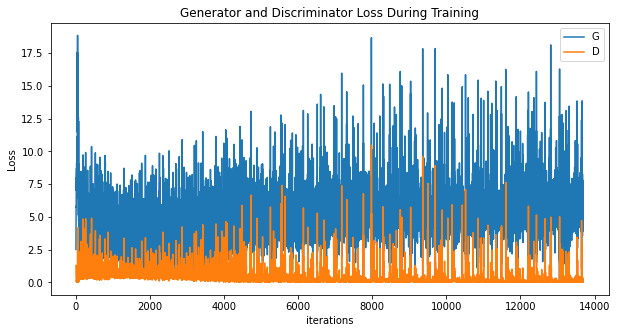

In [6]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(dcgan.lossesG, label="G")
plt.plot(dcgan.lossesD, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualization of Learned features

We can investigate the learned features at the first convolutional layer of the discriminator.

We can see in the plot that the result is a lot of versions of the initial image with different features highlighted

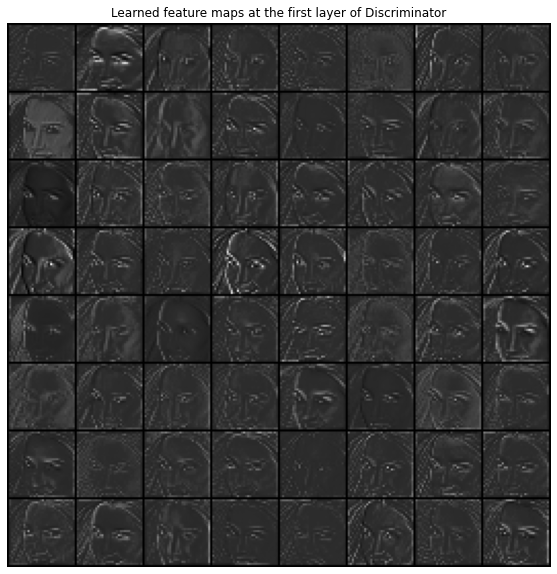

In [7]:
# Pick an input image
img = next(iter(celeba_loader))[0][0].unsqueeze(0)

# Retrieve the trained filters
filters = dcgan.get_disc_features(img).cpu()

# Visualize
grid_img = tv.utils.make_grid(filters[0].unsqueeze(1), nrow=8, normalize=True, padding=1)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
plt.title("Learned feature maps at the first layer of Discriminator")
plt.axis("off")
plt.show()

### Visualization of Fake images

We can now sample from the learned distribution

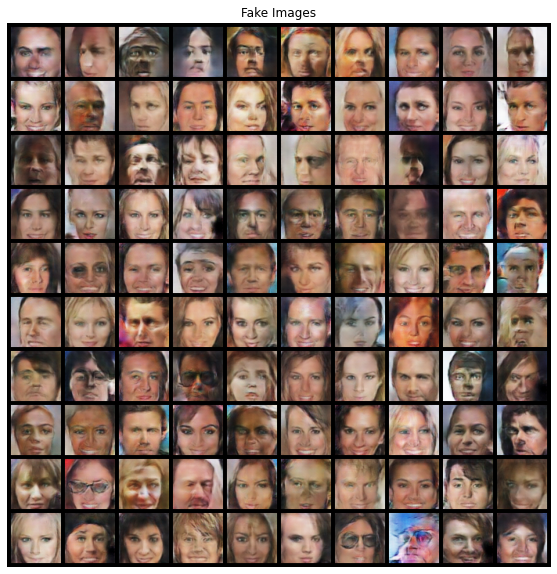

In [8]:
# Sampling
n_samples = 10 * 10
z = torch.randn(n_samples, z_dim, 1, 1)
x_fake = dcgan.sample(z)

# Visualization
grid_img = tv.utils.make_grid(x_fake, nrow=10, normalize=True, padding=5)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Fake Images")
plt.axis("off")
plt.show()

### Vector Arithmetic with Faces

Finally, I explore the latent space by performing vector arithmetic with the generated faces.

In order to do this, I **first** manually pick a few sets of faces from the previous vizualization of fake images.
And retrieve the corresponding latent vectors.

Each set must represent a specific feature. For example, `smiling_women`, `neutral_women` and `neutral_men`.

**Next**, I compute the average latent vector of each set (arithmetics on average vectors is more robust).

**Finally** The arithmetic operation can be performed then the generator is used on the resulting vector.

#### smiling woman - neutral woman + neutral man = smiling man

The first plot shows that the chosen sets are correct. The last image in each row is the average latent vector for that feature.

Finally we perform the arithmetic operation and plot the result.

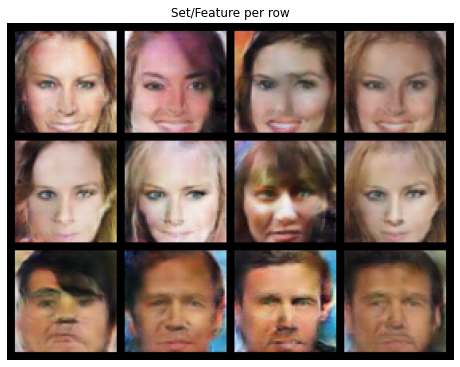

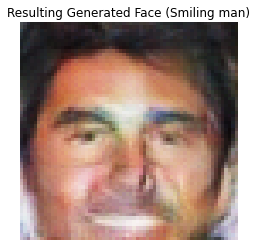

In [14]:
# Choose sets
smiling_women_indices = [32, 18, 28]
neutral_women_indices = [66, 90, 80]
neutral_men_indices = [60, 44, 72]

# Get latent vectors (z was defined previously when generating fake faces)
smiling_women_vects = z[smiling_women_indices]
neutral_women_vects = z[neutral_women_indices]
neutral_men_vects = z[neutral_men_indices]

# Get average latent vector of each set
avg_smiling_woman = smiling_women_vects.mean(0, keepdim=True)
avg_neutral_woman = neutral_women_vects.mean(0, keepdim=True)
avg_neutral_man = neutral_men_vects.mean(0, keepdim=True)

# Visualize chosen sets and their average
vects = torch.vstack((
    smiling_women_vects, avg_smiling_woman,
    neutral_women_vects, avg_neutral_woman,
    neutral_men_vects, avg_neutral_man,
))
images = dcgan.sample(vects)
grid_img = tv.utils.make_grid(images, nrow=4, normalize=True, padding=5)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Set/Feature per row")
plt.axis("off")
plt.show()

# Arithmetic operation
result = avg_smiling_woman - avg_neutral_woman - avg_neutral_woman + avg_neutral_man

# Generate anv visualize image
img = dcgan.sample(result)
img = (img + 1) / 2.0
plt.imshow(img[0].permute(1, 2, 0))
plt.title('Resulting Generated Face (Smiling man)')
plt.axis('off')
plt.show()